In [2]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.signal

%matplotlib inline

#%cd /Users/Tucker/CosmicRaySim/

In [3]:
""" MATERIAL PROPERTIES """

# Specific heat of silicon
cSi = 8.2e-10 # J / K / cm^3

# Specific heat of gold
cAu = 7.0e-6 # J / K / cm^3

# Thermal conductivity of silicon
kSi = 4.2e-3 # W / cm / K

# Thermal conductivity of gold
kAu = 1e-1 # W / cm / K

""" WAFER PROPERTIES """

# Length of the side of a square wafer
lengthSide = 8.5 # cm

# Thickness of silicon
thickSi = .3 # cm

# Thickness of gold
thickAu = 0 # um
thickAu = thickAu / 1e4 # cm

# 2d specific heat of wafer
cWafer = cSi * thickSi + cAu * thickAu # J / K / cm^2

# Heat capacity of wafer
cWafer = cWafer * lengthSide**2

# Conductance between wafer and focal plane
gWFP = 1e-4 # W / K

# Thermal time constant
tau = cWafer/gWFP

""" SIMULATION PARAMETERS """

# Timestep size
dt = tau/10. # s 

# Number of time-steps to evolve system.
nt=int(1e6)

# Cosmic ray hit rate
hitRate = 5 # hits/cm^2/s
hitRate = hitRate * 2 * lengthSide**2 # hits/s

# Proton/alpha fraction
pFrac = 0.9
aFrac = 0.1

In [4]:
def n_hits():
    
    """Draws number of hits in each timestep from Poisson distribution"""
    
    hits = {}
    hits["alpha"] = np.random.poisson(hitRate*aFrac*dt, size=nt)
    hits["proton"] = np.random.poisson(hitRate*pFrac*dt, size=nt)
    return hits

In [5]:
def incident_energy(size):
    
    """ Draws incident CR energy from distribution defined by L2Flux.txt
        
    Parameters
    ---------- 
    size : int
        Number of CR hits
    
    Returns
    -------
    incident_energy, list
        Incident energy of each CR
    """
        
    ke, p = np.loadtxt('L2Flux.txt',skiprows=3).T
    incident_energy = np.random.choice(ke, size=size, p=p)
    return incident_energy

In [15]:
ke, psp, asp = np.loadtxt('StoppingPower.txt',skiprows=5).T
stoppingPower = {}
stoppingPower["proton"] = [ke,psp]
stoppingPower["alpha"] = [ke,asp]

def deposited_energy(incident_energy,particle,n_steps=1e2):
    
    """ Integrates stopping power over thickness of silicon to calculate 
    the energy deposited by a cosmic ray
        
    Parameters
    ---------- 
    incident_energy : list
        Incident kinetic (MeV) energy of CR
        
    particle : str
        Type of incident particle, "alpha" or "proton"
        
    n_steps : float, default=1e2
        Number of discrete steps for integral
    
    Returns
    -------
    deposited_energy, float
        Result of integration, energy lost by particle (MeV)
    """
    n = len(incident_energy)
    deposited_energy = np.zeros(n)
    for i in range(n):
        deposited_energy[i] = 0
        for j in range(int(n_steps)):
            energy_lost = (thickSi/n_steps) * \
                np.interp(incident_energy[i] - deposited_energy[i], stoppingPower[particle][0], stoppingPower[particle][1])
            deposited_energy[i] += energy_lost
        if deposited_energy[i] > incident_energy[i]:
            deposited_energy[i] = incident_energy[i]
    return deposited_energy * 1.6e-13 # convert from MeV to J

In [16]:
def temperature(e_t):
    
    """ Creates simulated wafer temperature timestream
    
    Parameters
    ----------
    e_t : string
        Deposited energy at each timestep
        
    Returns
    -------
    temperature : string
        Temperature [K] of wafer at each timestep"""
    temperature = np.zeros(nt)
    for i in range(1,nt):
        temperature[i] = temperature[i-1]*np.exp(-dt/tau) + e_t[i]/cWafer
    temperature = temperature
    return temperature

In [17]:
def make_psd(temp):
    
    """ Make PSD of wafer temperature in units K**2/Hz
    
    Parameters
    ----------
    temp : string
        Temperature at each timestep
        
    Returns
    -------
    freq : string
        Sample frequencies
    psd : string
        psd amplitude in K**2/Hz
    """
    
    x = temp-np.mean(temp)
    freq, psd = scipy.signal.periodogram(x,1./dt)
    return freq, psd

In [18]:
time = np.linspace(0,nt*dt,nt)

# find number of hits in each timestep
hits = n_hits()

# find incident energy of each hit
incidents = {}
incidents['alpha'] = incident_energy(sum(hits['alpha']))
incidents['proton'] = incident_energy(sum(hits['proton']))

# find deposited energy of each hit
deposits = {}
deposits['alpha'] = deposited_energy(incidents['alpha'],'alpha')
deposits['proton'] = deposited_energy(incidents['proton'],'proton')

# find deposited energy in each timestep
et = np.zeros(nt)
for i in range(nt):
    counter = 0
    for j in range(hits['alpha'][i]):
        et[i] += deposits['alpha'][counter+j]
        counter += 1
    for j in range(hits['proton'][i]):
        et[i] += deposits['proton'][counter+j]
        counter += 1

# find wafer temperature at each timestep [K]
temp = temperature(e_t=et)

# make psd [K**2/Hz]
freq, psd = make_psd(temp=temp)

In [19]:
print freq

[  0.00000000e+00   5.62635384e-02   1.12527077e-01 ...,   2.81316567e+04
   2.81317129e+04   2.81317692e+04]


In [20]:
print psd 

[  3.90990045e-43   3.55795762e-15   8.92710948e-14 ...,   1.26803374e-16
   7.01351084e-17   5.27667814e-17]


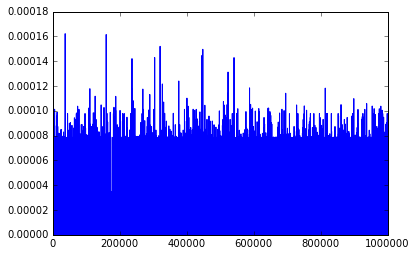

In [21]:
plt.plot(temp)